In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr

## A4: Common Analysis 

The goal of the common analysis question was to answer the question of "How masking policies changed the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?"

One item of note is that vaccination rate was not taken into account for this analysis.

Below I read in the data for 
1. mask_use, found at https://github.com/nytimes/covid-19-data/tree/master/mask-use
2. confirmed_cases and population data, found at https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv
3. mask_mandates, found at https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i


In [2]:
# reading in raw data
mask_use = pd.read_csv("raw-data/mask-use-by-county.csv")
confirmed_cases = pd.read_csv("raw-data/CONVENIENT_us_confirmed_cases.csv", header = [0,1])
mask_mandates = pd.read_csv("raw-data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
population_data = pd.read_csv("raw-data/CONVENIENT_us_metadata.csv")

#### Data cleaning

Next I make sure to only get information for my given county of Baltimore County in Maryland.

In [3]:
# get mask use for Baltimore County
baltimore_mask_use = mask_use[mask_use["COUNTYFP"] == 24005] #24005 is the code for Baltimore
# filtering confirmed cases for Baltimore County
baltimore_confirmed_cases = pd.DataFrame(data = list(zip(confirmed_cases['Province_State']['Admin2'], 
                                                         confirmed_cases['Maryland']['Baltimore'])), 
                                                         columns = ['date', 'confirmed_cases'])
# filtering mask mandates for Baltimore County
baltimore_mask_mandates = mask_mandates[mask_mandates["County_Name"] == "Baltimore County"]

# getting the population of Baltimore County
population_data = population_data[population_data["Admin2"] == "Baltimore"]

Next I filter the dates between February 1, 2020 to October 14, 2021 for my analysis.

In [4]:
# filtering dates of Baltimore County mask mandates
baltimore_mask_mandates["date"] = pd.to_datetime(baltimore_mask_mandates["date"]) 
baltimore_mask_mandates = baltimore_mask_mandates[baltimore_mask_mandates["date"] >= '2/1/2020']
baltimore_mask_mandates = baltimore_mask_mandates[baltimore_mask_mandates["date"] <= '10/15/2021']

C:\Users\geier\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
# filtering dates of Baltimore County confirmed cases
baltimore_confirmed_cases["date"] = pd.to_datetime(baltimore_confirmed_cases["date"]) 
baltimore_confirmed_cases = baltimore_confirmed_cases[baltimore_confirmed_cases["date"] >= '2/1/2020']
baltimore_confirmed_cases = baltimore_confirmed_cases[baltimore_confirmed_cases["date"] <= '10/15/2021']

In [6]:
# dropping all na values for mask mandates
baltimore_mask_mandates = baltimore_mask_mandates[baltimore_mask_mandates["Face_Masks_Required_in_Public"].notna()]

A rolling average of confirmed covid cases was calculated with a 7 day window to account for the delay between the time of infection and time a case is confirmed

In [7]:
# calculating a rolling case avaerage with a 7 day window this is to account for the delay
# between the time of infection and time a case is confirmed
# credit: This code is credited to Grant Savage from the class slack
baltimore_confirmed_cases["confirmed_cases_rolling_avg"] = baltimore_confirmed_cases.confirmed_cases.rolling(window=7).mean().round() 

In [8]:
# merging the confirmed cases and the mask mandates data set on the date
baltimore_confirmed_cases_mask_mandate = pd.merge(baltimore_confirmed_cases, baltimore_mask_mandates, left_on = "date", right_on = "date", how="outer")

In [9]:
# filtering for the relevant columns of date, confirmed_cases, confirmed_cases_rolling average, and the boolean - Face_Masks_Required_in_Public
baltimore_confirmed_cases_mask_mandate = baltimore_confirmed_cases_mask_mandate[["date", "confirmed_cases", "confirmed_cases_rolling_avg", "Face_Masks_Required_in_Public"]]

In [10]:
# calculating cumulative_cases by summing the confirmed cases
baltimore_confirmed_cases_mask_mandate["cumulative_cases"] = baltimore_confirmed_cases_mask_mandate["confirmed_cases"].cumsum()

I calculate infection rate as confirmed cases rolling average / population - cumulative cases.
Using this methodology I assume that once someone has infected they can no longer get Covid.

In [11]:
# getting the population number for Baltimore County
population = population_data["Population"].iloc[0]
# calculating the infection rate as the rolling average divided by the population - cumulative cases
# this assumes that people who have been infected cannot get reinfected
baltimore_confirmed_cases_mask_mandate["Infection_Rate"] = baltimore_confirmed_cases_mask_mandate['confirmed_cases_rolling_avg'].div(population -baltimore_confirmed_cases_mask_mandate['cumulative_cases'])

In [12]:
# Next I get Infection rate per 1000 people-days by multiplying the infection rate by 1000
baltimore_confirmed_cases_mask_mandate["Infection_Rate_per_1000"] = baltimore_confirmed_cases_mask_mandate["Infection_Rate"] * 1000

In [13]:
# I calculate the change in infection rate as the change in infection rate per 100 people-days
baltimore_confirmed_cases_mask_mandate["change_infection_rate"] = baltimore_confirmed_cases_mask_mandate["Infection_Rate_per_1000"].diff()

In [14]:
# the percent change in infection rate is calculated as the change in infection rate 
# divided by the infection rate per 1000 people-days
baltimore_confirmed_cases_mask_mandate["percent_change_infection_rate"] = (baltimore_confirmed_cases_mask_mandate["change_infection_rate"].div(baltimore_confirmed_cases_mask_mandate["Infection_Rate_per_1000"].shift(1))* 100)

#### Data Visualization

Next I create some data visualizations to further explore the data.

#### Cumulative Cases in Baltimore County Maryland with Masking Mandate

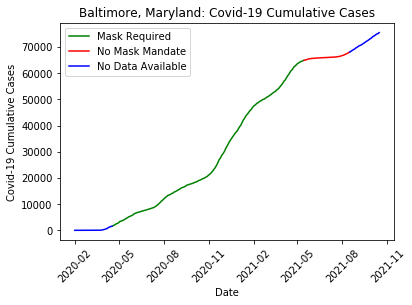

In [15]:
fig, ax = plt.subplots()

# plotting cumulative cases and using colors where green signifies a mask policy, red signifies no masking policy
# and blue signifies no data on if a masking policy is in place
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['cumulative_cases'] if x['Face_Masks_Required_in_Public'] =='Yes' else np.nan, axis=1),
color = 'g',
label='Mask Required')
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['cumulative_cases'] if x['Face_Masks_Required_in_Public'] =='No' else np.nan, axis=1),
color = 'r',
label='No Mask Mandate')
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['cumulative_cases'] if (x['Face_Masks_Required_in_Public'] !='Yes' and x['Face_Masks_Required_in_Public'] !='No' ) else np.nan, axis=1),
color = 'b',
label='No Data Available')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation = 45)

plt.title('Baltimore, Maryland: Covid-19 Cumulative Cases')
plt.xlabel('Date')
plt.ylabel('Covid-19 Cumulative Cases')
plt.legend()
plt.show()  

#### Infection Rate in Baltimore County Maryland with Masking Mandate

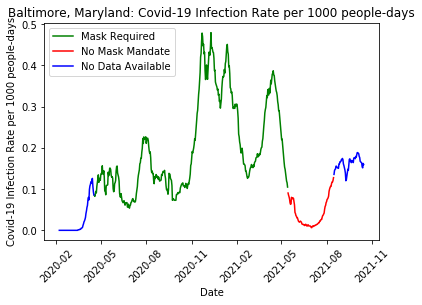

In [16]:
fig, ax = plt.subplots()

# plotting infection rate per 1000 people days and using colors where green signifies a mask policy,
# red signifies no masking policy and blue signifies no data on if a masking policy is in place
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['Infection_Rate_per_1000'] if x['Face_Masks_Required_in_Public'] =='Yes' else np.nan, axis=1),
color = 'g',
label='Mask Required')
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['Infection_Rate_per_1000'] if x['Face_Masks_Required_in_Public'] =='No' else np.nan, axis=1),
color = 'r',
label='No Mask Mandate')
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['Infection_Rate_per_1000'] if (x['Face_Masks_Required_in_Public'] !='Yes' and x['Face_Masks_Required_in_Public'] !='No' ) else np.nan, axis=1),
color = 'b',
label='No Data Available')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation = 45)

plt.title('Baltimore, Maryland: Covid-19 Infection Rate per 1000 people-days')
plt.xlabel('Date')
plt.ylabel('Covid-19 Infection Rate per 1000 people-days')
plt.legend()
plt.show()    

#### Change in daily infection rate in Baltimore County Maryland with Masking Mandate

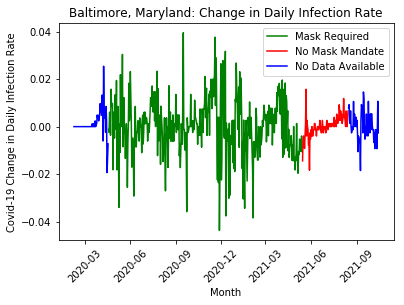

In [17]:
fig, ax = plt.subplots()

# plotting change in infection rate and using colors where green signifies a mask policy,
# red signifies no masking policy and blue signifies no data on if a masking policy is in place
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['change_infection_rate'] if x['Face_Masks_Required_in_Public'] =='Yes' else np.nan, axis=1),
color = 'g',
label='Mask Required')
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['change_infection_rate'] if x['Face_Masks_Required_in_Public'] =='No' else np.nan, axis=1),
color = 'r',
label='No Mask Mandate')
plt.plot(baltimore_confirmed_cases_mask_mandate['date'],
baltimore_confirmed_cases_mask_mandate.apply(lambda x: x['change_infection_rate'] if (x['Face_Masks_Required_in_Public'] !='Yes' and x['Face_Masks_Required_in_Public'] !='No' ) else np.nan, axis=1),
color = 'b',
label='No Data Available')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.xticks(rotation = 45)

plt.title('Baltimore, Maryland: Change in Daily Infection Rate')
plt.xlabel('Month')
plt.ylabel('Covid-19 Change in Daily Infection Rate')
plt.legend()
plt.show()   


#### Probability of wearing a mask in Baltimore County, Maryland

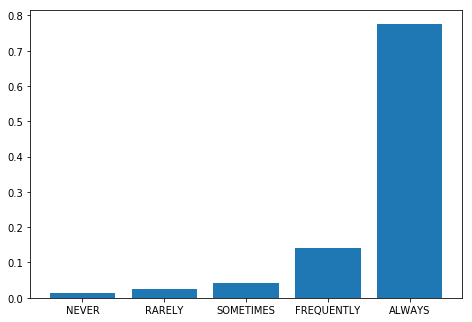

In [18]:
# creating a bar chart with the probability of never, rarely, sometimes, frequently and always wearing a mask
# credit to Aaliyah Hanni for the visualization idea from the class slack channel
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = list(baltimore_mask_use[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']])
probabilities = list(baltimore_mask_use[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']].iloc[0])
ax.bar(categories, probabilities)
plt.show()

## A7: Extension Plan

The goal of the common analysis question was to answer the questions of: 
1. What is the relationship between Covid-19 infection rate and unemployment rate in Baltimore County?
2. What is the relationship between Covid-19 infection rate and crime reports in Baltimore County?

Below I read in the data for 
1. Baltimore County Unemployment Rate, found at https://www.bls.gov/eag/eag.md_baltimore_msa.htm
2. crime report data, found at https://app.powerbigov.us/view?r=eyJrIjoiZmEyNTg0ODEtYmM0Ni00YzMyLWI3N2QtMWI5NzNmMDE3MWE0IiwidCI6Ijk0NGZhOWJhLTg0NTQtNDEzZC1iOWU2LWJmNDBhZjFkNmE5YiJ9
3. Maryland state insured unemployment rate, found at https://oui.doleta.gov/unemploy/claims.asp?fbclid=IwAR0noEYCm-sz8CVgTZd99IPQCJ8es_HCDOPnsFgO7MTrSQoUiTTVR3pLR5g

In [19]:
# reading in raw data
bc_unemployment = pd.read_csv("raw-data/unemployment.csv")
crime = pd.read_csv("raw-data/crime_data.csv")
maryland_unemployment = pd.read_csv("raw-data/maryland_unemployment.csv")

#### Data cleaning

Below I perform some data cleaning on the Baltimore County unemployment rate, Crime reports, 
and Maryland Insured Unemployment rate data sets.

In [20]:
# converting the dates to datetime 
bc_unemployment['datetime'] = pd.to_datetime(bc_unemployment['date'], format='%b-%y')
crime['datetime'] = pd.to_datetime(crime['Date'], format='%y-%b')
maryland_unemployment["Reflecting Week Ended"] = pd.to_datetime(maryland_unemployment["Reflecting Week Ended"]) 

In [21]:
# setting date as the index for confirmed cases
monthly_covid = baltimore_confirmed_cases_mask_mandate.set_index("date")

In [22]:
# calculating monthly covid cases as the monthly sum of confirmed cases
monthly_covid = monthly_covid['confirmed_cases'].resample('MS', convention = "start" ).sum()

# calculate weekly covid cases
weekly_covid = baltimore_confirmed_cases_mask_mandate.set_index("date")
weekly_covid = weekly_covid['confirmed_cases'].resample('W-SAT', convention = "start" ).sum()

In [23]:
# calculate monthly infection rate 
monthly_infection_rate = pd.DataFrame(monthly_covid.div(population))
monthly_infection_rate = monthly_infection_rate.rename(columns ={ "confirmed_cases" : "infection_rate"})

# calculating weekly infection rate
weekly_infection_rate = pd.DataFrame(weekly_covid.div(population))
weekly_infection_rate = weekly_infection_rate.rename(columns ={ "confirmed_cases" : "infection_rate"})

In [24]:
# merging the monthly infection rate with the crime reports
covid_crime = pd.merge(monthly_infection_rate, crime, left_index = True, right_on = "datetime", how="inner")
# merging monthly infection rate, crime reports, and baltimore county unemployment rate
covid_crime_unemployment = pd.merge(covid_crime, bc_unemployment, left_on = "datetime", right_on = "datetime", how="inner")

In [25]:
# getting relevant columns of date, infection_rate, Arson, Assault, Burglary, Homicide, MVT, Sexual Assault, Robbery, Total Crimes, labor force, employment, unemployment, and unemployment rate
covid_crime_unemployment = covid_crime_unemployment[['datetime','infection_rate', 'Arson', 'Assault', 'Burglary', 'Homicide', 'Motor Vehicle Theft', 'Sexual Assault', 'Robbery','Total', 'labor force', 'employment', 'unemployment', 'unemployment rate']]

In [26]:
# splitting up crime reports into 2020 and 2021 since statistical comparisons can't be made across years
covid_crime_unemployment_2021 = covid_crime_unemployment[covid_crime_unemployment["datetime"] > '2020-12-31']
covid_crime_unemployment_2020 = covid_crime_unemployment[covid_crime_unemployment["datetime"] <= '2020-12-31']

In [27]:
# filtering date in maryland unemployment rate for between 2/1/2020 and 10/15/2021
maryland_unemployment = maryland_unemployment[maryland_unemployment["Reflecting Week Ended"] >= '2/1/2020']
maryland_unemployment = maryland_unemployment[maryland_unemployment["Reflecting Week Ended"] <= '10/15/2021']

In [28]:
# merging weekly infection rate with maryland insured unemployment rate data
maryland_unemployment_infection = pd.merge(weekly_infection_rate, maryland_unemployment, left_index = True, right_on = "Reflecting Week Ended", how="inner")

Creating cross correlation function and finding optimal lag

In [29]:
# Time lagged cross correlation
# takes in an x data, y data, and a lag
# returns a correlation coefficient

# credit: this function was found on towards data science
# at https://towardsdatascience.com/computing-cross-correlation-between-geophysical-time-series-488642be7bf0
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [30]:
# calculating multiple cross correlations to find optimal lag time 
for x in range(-40, 40):
    print(crosscorr(maryland_unemployment_infection['Insured Unemployment Rate'],maryland_unemployment_infection['infection_rate'], x), "lag:", x)

-0.13778297977250206 lag: -40
-0.03296723946958197 lag: -39
0.07518434495990489 lag: -38
0.19108437059728556 lag: -37
0.3127556948037821 lag: -36
0.4391772889349873 lag: -35
0.5583740368926755 lag: -34
0.6587147840972721 lag: -33
0.7406029000950222 lag: -32
0.7836706080799108 lag: -31
0.791642815575251 lag: -30
0.7762871108524068 lag: -29
0.734371942122764 lag: -28
0.6714668383898372 lag: -27
0.5942427638146909 lag: -26
0.5173277268535408 lag: -25
0.46623501733445055 lag: -24
0.4279008989513476 lag: -23
0.3974092810553139 lag: -22
0.37647918151616855 lag: -21
0.3569222838641587 lag: -20
0.34208834464982285 lag: -19
0.32627129165502694 lag: -18
0.31346840743746657 lag: -17
0.29768825855113645 lag: -16
0.26371478941247095 lag: -15
0.22919139480850695 lag: -14
0.18443544412926885 lag: -13
0.13984009654792398 lag: -12
0.09673099094340043 lag: -11
0.04806034040677383 lag: -10
0.013771769083486825 lag: -9
-0.013795255124729426 lag: -8
-0.03534147149206148 lag: -7
-0.049975683824533414 lag: -

In [31]:
# applying optimal lag time of -30 weeks 
maryland_unemployment_infection["lagged_infection_rate"] = maryland_unemployment_infection["infection_rate"].shift(-30)

In [32]:
# dropping na values due to the lag
maryland_unemployment_infection = maryland_unemployment_infection.dropna(axis=0)

#### Correlation of infection rate with insured unemployment rate in Maryland

In [33]:
pearsonr(maryland_unemployment_infection['infection_rate'], maryland_unemployment_infection['Insured Unemployment Rate'])

(-0.14082963228006096, 0.2873734289841665)

#### Correlation of lagged infection rate with insured unemployment rate in Maryland

In [34]:
# calculating correlation with lagged infection rate and p-value
pearsonr(maryland_unemployment_infection['lagged_infection_rate'], maryland_unemployment_infection['Insured Unemployment Rate'])

(0.791642815575251, 8.375161908698755e-14)

In [35]:
# looking at correlation coefficients of all crime types in 2020
covid_crime_unemployment_2020.corr()

,infection_rate,Arson,Assault,Burglary,Homicide,Motor Vehicle Theft,Sexual Assault,Robbery,Total,labor force,employment,unemployment,unemployment rate
infection_rate,1.000000,-0.065564,0.183908,0.199246,0.206719,-0.179217,0.389021,0.146690,0.219013,-0.431049,-0.395635,0.174379,0.203857
Arson,-0.065564,1.000000,0.136049,0.026325,0.005450,-0.307051,-0.156215,0.346830,0.108160,0.585554,0.640526,-0.443492,-0.491094
Assault,0.183908,0.136049,1.000000,0.366649,-0.032621,0.027105,-0.381047,0.242770,0.953793,0.215429,0.123932,0.060769,0.045337
Burglary,0.199246,0.026325,0.366649,1.000000,-0.327256,-0.423653,-0.007556,0.248296,0.459407,-0.023858,0.215453,-0.466086,-0.447396
Homicide,0.206719,0.005450,-0.032621,-0.327256,1.000000,0.356783,0.092422,-0.338393,-0.046742,0.372308,0.162990,0.207625,0.166717
Motor Vehicle Theft,-0.179217,-0.307051,0.027105,-0.423653,0.356783,1.000000,-0.070424,-0.359755,0.114304,0.353416,0.127674,0.251298,0.209868
Sexual Assault,0.389021,-0.156215,-0.381047,-0.007556,0.092422,-0.070424,1.000000,0.438125,-0.177485,-0.345820,-0.189071,-0.117335,-0.098676
Robbery,0.146690,0.346830,0.242770,0.248296,-0.338393,-0.359755,0.438125,1.000000,0.390428,-0.047757,0.268159,-0.606026,-0.584354
Total,0.219013,0.108160,0.953793,0.459407,-0.046742,0.114304,-0.177485,0.390428,1.000000,0.241907,0.225823,-0.105458,-0.120856
labor force,-0.431049,0.585554,0.215429,-0.023858,0.372308,0.353416,-0.345820,-0.047757,0.241907,1.000000,0.882500,-0.333705,-0.417168


In [36]:
# looking at correlation coefficients of all crime types in 2021
covid_crime_unemployment_2021.corr()

,infection_rate,Arson,Assault,Burglary,Homicide,Motor Vehicle Theft,Sexual Assault,Robbery,Total,labor force,employment,unemployment,unemployment rate
infection_rate,1.000000,-0.658691,-0.537807,-0.381046,-0.252557,-0.414145,-0.403354,-0.569264,-0.571728,-0.734507,-0.668855,-0.072682,0.014964
Arson,-0.658691,1.000000,0.350474,0.154783,0.149615,0.501397,0.854256,0.192037,0.419463,0.814036,0.745589,0.066244,-0.050667
Assault,-0.537807,0.350474,1.000000,0.730791,-0.410033,0.808666,0.308401,0.754914,0.993281,0.593106,0.684891,-0.421449,-0.504000
Burglary,-0.381046,0.154783,0.730791,1.000000,-0.552495,0.385122,0.281820,0.828290,0.764066,0.577869,0.679644,-0.451565,-0.548757
Homicide,-0.252557,0.149615,-0.410033,-0.552495,1.000000,-0.259893,-0.144296,-0.354503,-0.406230,-0.177468,-0.211831,0.148982,0.217702
Motor Vehicle Theft,-0.414145,0.501397,0.808666,0.385122,-0.259893,1.000000,0.406200,0.455079,0.825922,0.410945,0.508563,-0.404829,-0.449271
Sexual Assault,-0.403354,0.854256,0.308401,0.281820,-0.144296,0.406200,1.000000,0.043216,0.378235,0.815962,0.760572,0.022570,-0.117852
Robbery,-0.569264,0.192037,0.754914,0.828290,-0.354503,0.455079,0.043216,1.000000,0.776074,0.474570,0.511244,-0.215303,-0.280527
Total,-0.571728,0.419463,0.993281,0.764066,-0.406230,0.825922,0.378235,0.776074,1.000000,0.643327,0.733197,-0.425012,-0.515243
labor force,-0.734507,0.814036,0.593106,0.577869,-0.177468,0.410945,0.815962,0.474570,0.643327,1.000000,0.953531,-0.043348,-0.203871


#### Correlation of total crime count with infection rate in 2020

In [37]:
# calculating correlation coefficient and p-value
pearsonr(covid_crime_unemployment_2020['Total'], covid_crime_unemployment_2020['infection_rate'])

(0.21901310459105713, 0.5176176549674969)

#### Correlation of total crime count with infection rate in 2021

In [38]:
# calculating correlation coefficient and p-value
pearsonr(covid_crime_unemployment_2021['Total'], covid_crime_unemployment_2021['infection_rate'])

(-0.5717276423295926, 0.10775901952466405)

#### Correlation of unemployment rate with total crime count in 2020

In [39]:
pearsonr(covid_crime_unemployment_2020['unemployment rate'], covid_crime_unemployment_2020['Total'])

(-0.12085633262858753, 0.7233637637637849)

#### Correlation of unemployment rate with total crime count in 2021

In [40]:
pearsonr(covid_crime_unemployment_2021['unemployment rate'], covid_crime_unemployment_2021['Total'])

(-0.5152427191135034, 0.1557281166512434)

#### Data Visualization

Below I create some plots to help in my analysis.

#### Baltimore County Monthly Infection Rate vs Crime Reports in 2020

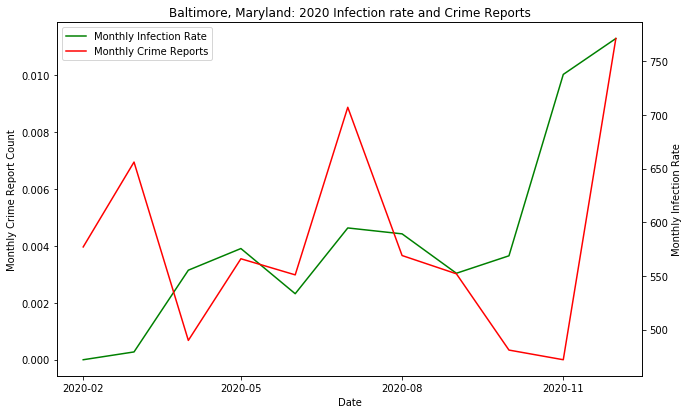

In [41]:
fig, ax = plt.subplots()

# infection rate vs monthly crime reports
ax.plot(covid_crime_unemployment_2020['datetime'],
covid_crime_unemployment_2020.apply(lambda x: x['infection_rate'], axis=1), color = 'g', label = "Monthly Infection Rate")
ax_2 = ax.twinx()

ax_2.plot(covid_crime_unemployment_2020['datetime'],
covid_crime_unemployment_2020.apply(lambda x: x['Total'], axis=1), color = 'r', label = "Monthly Crime Reports")

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Report Count')
ax_2.set_ylabel("Monthly Infection Rate")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.xticks(rotation = 45)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.set_size_inches(10.5, 6.5)
plt.title('Baltimore, Maryland: 2020 Infection rate and Crime Reports')
plt.legend(handles,labels)
plt.show()

#### Baltimore County Monthly Infection Rate vs Crime Reports in 2021

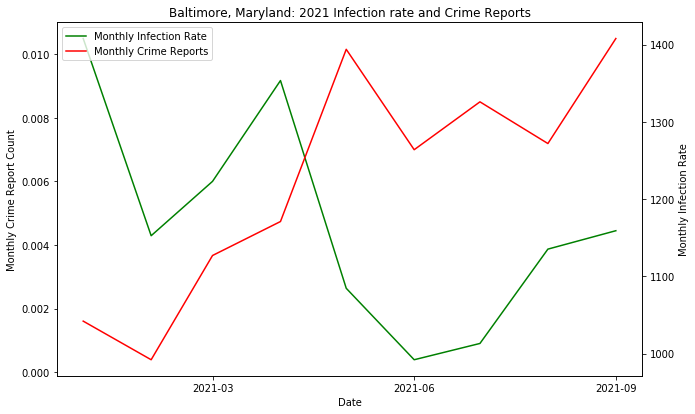

In [42]:
fig, ax = plt.subplots()

# infection rate vs monthly crime reports
ax.plot(covid_crime_unemployment_2021['datetime'],
covid_crime_unemployment_2021.apply(lambda x: x['infection_rate'], axis=1), color = 'g', label = "Monthly Infection Rate")
ax_2 = ax.twinx()

ax_2.plot(covid_crime_unemployment_2021['datetime'],
covid_crime_unemployment_2021.apply(lambda x: x['Total'], axis=1), color = 'r', label = "Monthly Crime Reports")

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Report Count')
ax_2.set_ylabel("Monthly Infection Rate")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.xticks(rotation = 45)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.set_size_inches(10.5, 6.5)
plt.title('Baltimore, Maryland: 2021 Infection rate and Crime Reports')
plt.legend(handles,labels)
plt.show()  

#### Monthly unemployment rate vs crime reports in 2020

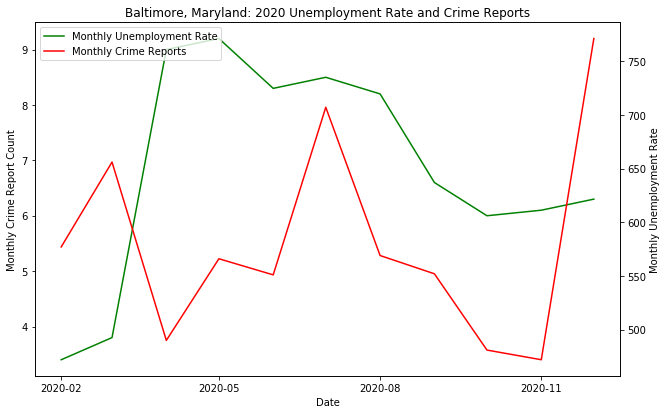

In [43]:
fig, ax = plt.subplots()


ax.plot(covid_crime_unemployment_2020['datetime'],
covid_crime_unemployment_2020.apply(lambda x: x['unemployment rate'], axis=1), color = 'g', label = "Monthly Unemployment Rate")
ax_2 = ax.twinx()

ax_2.plot(covid_crime_unemployment_2020['datetime'],
covid_crime_unemployment_2020.apply(lambda x: x['Total'], axis=1), color = 'r', label = "Monthly Crime Reports")

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Report Count')
ax_2.set_ylabel("Monthly Unemployment Rate")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation = 45)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.set_size_inches(10.5, 6.5)
plt.title('Baltimore, Maryland: 2020 Unemployment Rate and Crime Reports')
plt.legend(handles,labels)
plt.show()

#### Monthly unemployment rate vs crime reports in 2021

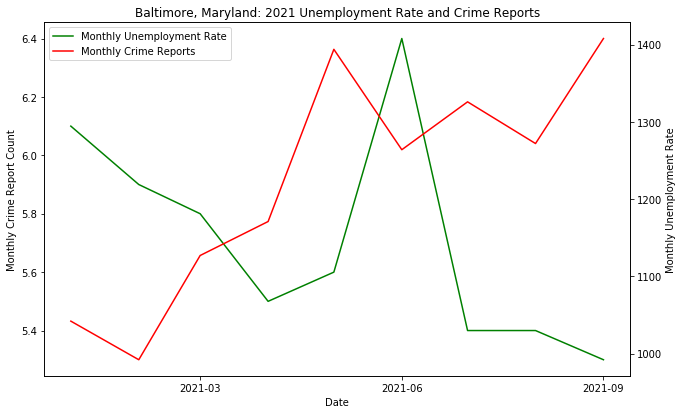

In [44]:
fig, ax = plt.subplots()


ax.plot(covid_crime_unemployment_2021['datetime'],
covid_crime_unemployment_2021.apply(lambda x: x['unemployment rate'], axis=1), color = 'g', label = "Monthly Unemployment Rate")
ax_2 = ax.twinx()

ax_2.plot(covid_crime_unemployment_2021['datetime'],
covid_crime_unemployment_2021.apply(lambda x: x['Total'], axis=1), color = 'r', label = "Monthly Crime Reports")

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Report Count')
ax_2.set_ylabel("Monthly Unemployment Rate")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.xticks(rotation = 45)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.set_size_inches(10.5, 6.5)
plt.title('Baltimore, Maryland: 2021 Unemployment Rate and Crime Reports')
plt.legend(handles,labels)
plt.show()

#### Baltimore County Maryland Monthly Unemployment Rate with Infection Rate

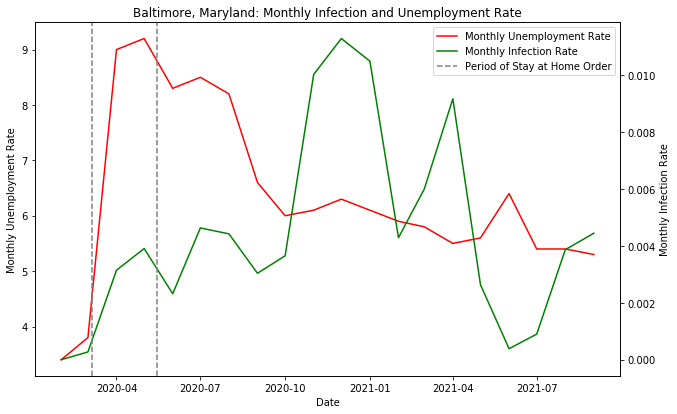

In [45]:
fig, ax = plt.subplots()


ax.plot(covid_crime_unemployment['datetime'],
covid_crime_unemployment.apply(lambda x: x['unemployment rate'], axis=1), color = 'r', label = "Monthly Unemployment Rate")
ax_2 = ax.twinx()

ax_2.plot(covid_crime_unemployment['datetime'],
covid_crime_unemployment.apply(lambda x: x['infection_rate'], axis=1), color = 'g', label = "Monthly Infection Rate")

plt.axvline(datetime(2020,3,5), color ="grey", linestyle = "--")
plt.axvline(datetime(2020,5,15), color = "grey", linestyle="--", label= "Period of Stay at Home Order")

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Unemployment Rate')
ax_2.set_ylabel("Monthly Infection Rate")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.xticks(rotation = 45)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.set_size_inches(10.5, 6.5)
plt.title('Baltimore, Maryland: Monthly Infection and Unemployment Rate')
plt.legend(handles,labels)
plt.show()

#### Maryland Infection rate and Insured Unemployment Rate

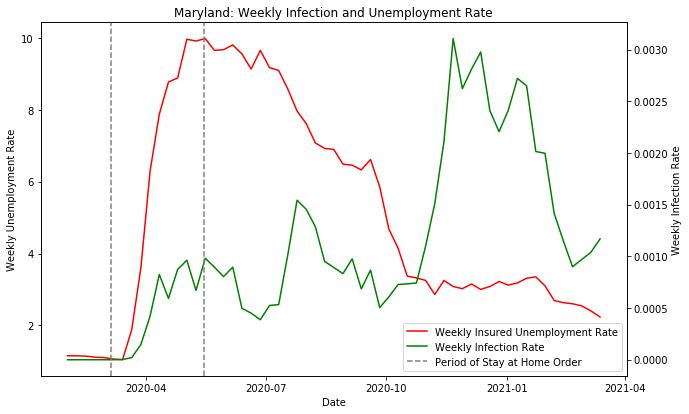

In [46]:
fig, ax = plt.subplots()

# plotting insured unemployment rate with weekly insured unemployment rate
ax.plot(maryland_unemployment_infection['Reflecting Week Ended'],
maryland_unemployment_infection.apply(lambda x: x['Insured Unemployment Rate'], axis=1), color = 'r', label = "Weekly Insured Unemployment Rate")
ax_2 = ax.twinx()

ax_2.plot(maryland_unemployment_infection['Reflecting Week Ended'],
maryland_unemployment_infection.apply(lambda x: x['infection_rate'], axis=1), color = 'g', label = "Weekly Infection Rate")

plt.axvline(datetime(2020,3,5), color ="grey", linestyle = "--")
plt.axvline(datetime(2020,5,15), color = "grey", linestyle="--", label= "Period of Stay at Home Order")

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Unemployment Rate')
ax_2.set_ylabel("Weekly Infection Rate")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.xticks(rotation = 45)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.set_size_inches(10.5, 6.5)
plt.title('Maryland: Weekly Infection and Unemployment Rate')
plt.legend(handles,labels)
plt.show()

#### Maryland Infection rate and Insured Unemployment Rate with lag

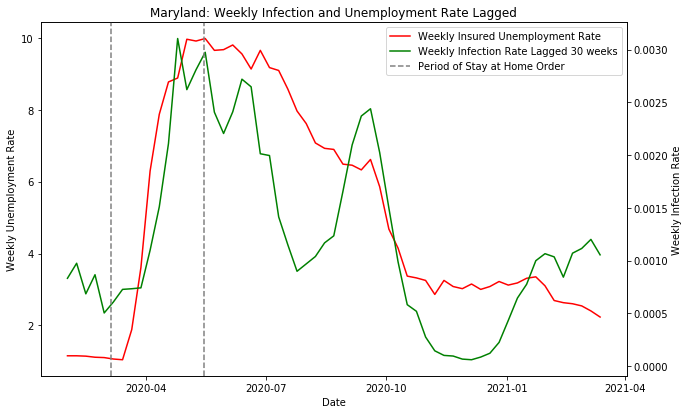

In [47]:
fig, ax = plt.subplots()

# plotting insured unemployment rate and lagged infection rate in maryland
ax.plot(maryland_unemployment_infection['Reflecting Week Ended'],
maryland_unemployment_infection.apply(lambda x: x['Insured Unemployment Rate'], axis=1), color = 'r', label = "Weekly Insured Unemployment Rate")
ax_2 = ax.twinx()

ax_2.plot(maryland_unemployment_infection['Reflecting Week Ended'],
maryland_unemployment_infection.apply(lambda x: x['lagged_infection_rate'], axis=1), color = 'g', label = "Weekly Infection Rate Lagged 30 weeks")

plt.axvline(datetime(2020,3,5), color ="grey", linestyle = "--")
plt.axvline(datetime(2020,5,15), color = "grey", linestyle="--", label= "Period of Stay at Home Order")

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Unemployment Rate')
ax_2.set_ylabel("Weekly Infection Rate")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation = 45)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.set_size_inches(10.5, 6.5)
plt.title('Maryland: Weekly Infection and Unemployment Rate Lagged')
plt.legend(handles,labels)
plt.show()